# Задание №2 CNN (сверточная нейросеть)
Задача классификации

Реализовав сверточную нейронную сеть при помощи библиотеки PyTorch, решите задачу классификации изображений (могут быть не только изображения, а численные переменные и текст). Разделите набор данных на обучающее и тестовое множество. Выполните предобработку данных (приведите изображения к одному размеру и преобразуйте в тензоры). Отобразите графики значений функции потерь на обучающем множестве. Отобразите confusion matrix и classification report, рассчитанные на основе тестового множества.
- Датасет: images/chars. (20 баллов)


In [61]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [62]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
print(device)

cpu


Image transformations

In [64]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5,0.5,0.5])
])

Dataloaders

In [65]:
#Path for training and testing directory
train_path='PandasBears/Train'
test_path='PandasBears/Test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=50, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=25, shuffle=True
)

Extracting categories

In [66]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [67]:
print(classes)

['.DS_Store', 'Bears', 'Pandas']


In [68]:
#use in case something sinks in
classes.pop(0)

'.DS_Store'

CNN Network

In [69]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output


Learning params

In [70]:
model=ConvNet(num_classes=2).to(device)

In [71]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [72]:
num_epochs=5

Set's lengths

In [73]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/*/*'))
test_count=len(glob.glob(test_path+'/*/*'))

In [74]:
print(train_count,test_count)

500 100


Model training and saving best model

In [75]:
best_accuracy=0.0
lossHist = []
test_pred = []
test_true = []
# test_pred1 = []
# test_true1 = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))


    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    lossHist.append(train_loss.detach().numpy())
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        # test_pred1.append(prediction)
        # test_true1.append(labels)


    test_pred.append(prediction)
    test_true.append(labels)
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy


Epoch: 0 Train Loss: tensor(7.1352) Train Accuracy: 0.784 Test Accuracy: 0.89
Epoch: 1 Train Loss: tensor(0.6990) Train Accuracy: 0.984 Test Accuracy: 0.92
Epoch: 2 Train Loss: tensor(0.1747) Train Accuracy: 0.996 Test Accuracy: 0.99
Epoch: 3 Train Loss: tensor(0.) Train Accuracy: 1.0 Test Accuracy: 1.0
Epoch: 4 Train Loss: tensor(0.0242) Train Accuracy: 0.998 Test Accuracy: 1.0


Data for loss graph

In [115]:
print(len(lossHist))
print(lossHist)

5
[array(7.135188, dtype=float32), array(0.6990492, dtype=float32), array(0.1746522, dtype=float32), array(0., dtype=float32), array(0.02415455, dtype=float32)]


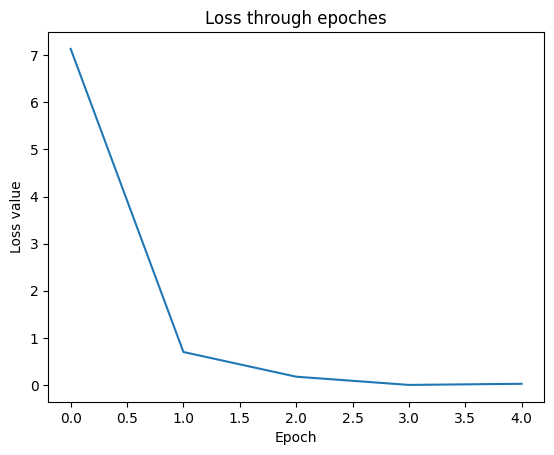

In [116]:
plt.plot(lossHist)
plt.title('Loss through epoches')
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

True and predicted values on test data

In [79]:
print(len(test_true))
print(len(test_pred))

5
5


In [87]:
print(test_true)
print(test_pred)

[tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1]), tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0]), tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1]), tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0]), tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0])]
[tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1]), tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1]), tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1]), tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0]), tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0])]


In [96]:
# print(len(test_true1))
# print(len(test_pred1))
# print(test_true1)
# print(test_pred1)

Joining tensors in each

In [91]:
T = test_true[0]
for t in test_true[1:]:
    T = torch.cat((T, t))
len(T)

125

In [92]:
T_pred = test_pred[0]
for t in test_pred[1:]:
    T_pred = torch.cat((T_pred, t))
len(T_pred)

125

In [95]:
# T1 = test_true1[0]
# for t in test_true1[1:]:
#     T1 = torch.cat((T1, t))
# len(T1)
#
# T_pred1 = test_pred1[0]
# for t in test_pred1[1:]:
#     T_pred1 = torch.cat((T_pred1, t))
#
# len(T_pred1)

Confusion matrix

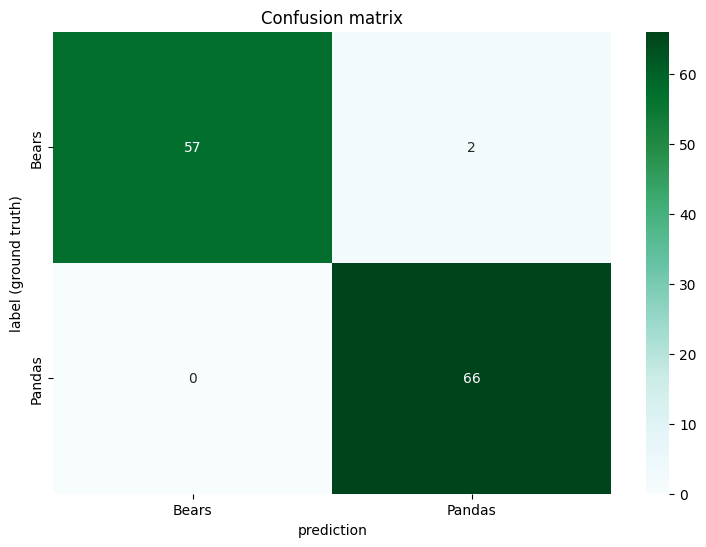

In [114]:
arr = confusion_matrix(T.view(-1).detach().cpu().numpy(), T_pred.view(-1).detach().cpu().numpy())
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.title('Confusion matrix')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Confusion matrix (alternative)

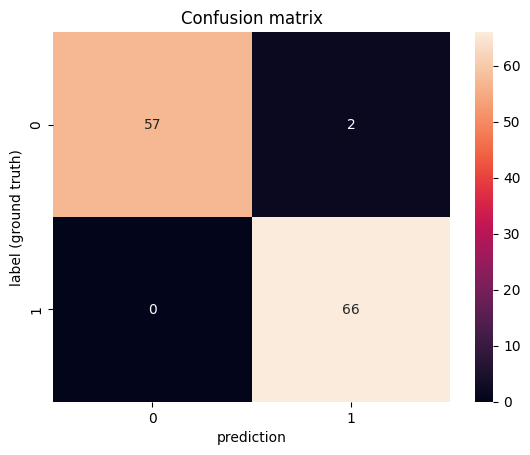

In [113]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(T, T_pred))
sns.heatmap(confusion_matrix_df, annot=True)
plt.title('Confusion matrix')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Classification report

In [99]:
print(classification_report(T, T_pred, target_names=classes))

              precision    recall  f1-score   support

       Bears       1.00      0.97      0.98        59
      Pandas       0.97      1.00      0.99        66

    accuracy                           0.98       125
   macro avg       0.99      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125

